# Working event enrichment: calendar movement segmentation and categorization
This script requires "Similar cache", which is a loadable dict of words related to categories to determine the categorization of events.
Also requires personicle json from firebase.

In [1]:
from spellchecker import SpellChecker
import spacy
import json
import matplotlib.pyplot as plt
import numpy as np
import jsonfix
from pprint import pprint
import csv
import scipy.signal
import datetime
nlp = spacy.load('en_core_web_lg')

In [2]:
# load data with custom json fixer for fixing json downloaded from firebase (dicts sometimes arrays)
data = jsonfix.fix_json("D:\\Research\\jordan.json")
lifeLog = data['lifeLog']

In [3]:
# "cal" is loaded in with every calendar event, as an array
# [name, location, time, day, timewindow (rearranged for consistency)]
cal = []
for k in lifeLog:
    for r in lifeLog[k]["mobile"].values():
        if r == None:
            continue
        if "calendar" in r:
            for j in r["calendar"]["labeledCalendar"]:
                tw = r['time']['timeWindow'] 
                tw = tw[4:8] + "_"+ tw[0:4] + tw[8:]
                cal.append([j["event"], j["location"], j["startTime"], k, tw ])
    

In [4]:
cal_filtered = []
#filter same events from consecutive time windows
cal = sorted(cal,key=lambda x:x[0])
i = 0
while i < len(cal):
    cal_filtered.append(cal[i])
    #this becomes the length of the event
    cal_filtered[-1].append(0)
    prev = cal[i][:3]
    while cal[i][:3] == prev:
        cal_filtered[-1][-1] += 5
        i+=1
        if i >= len(cal):
            break
        
cal = cal_filtered

In [5]:
# get the movement windows into an array
classified_minute_windows = []
with open('symbolicResultWorking.csv') as f:
    csvFile = csv.reader(f,delimiter=',')
    prev = ''
    total = 0
    for line in csvFile:
        if int(line[0][-3:]) != prev:
            classified_minute_windows.append({'moving':[line[5]]})
            classified_minute_windows[-1]['date'] = datetime.datetime(int(line[0][5:9]),int(line[0][0:2]),int(line[0][2:4]),
                                                                      hour=int(line[1][:-3]),
                                                                      minute=int(line[1][-2:])
                                                                     )
            classified_minute_windows[-1]['segment'] = int(line[0][10:13]) + int(total/5)
            classified_minute_windows[-1]['origSegment'] = int(line[0][10:13])
            classified_minute_windows[-1]['segNum'] = int(line[0][-3:])
            prev = int(line[0][-3:])
            if len(classified_minute_windows) > 1 and \
                    classified_minute_windows[-1]['origSegment'] != classified_minute_windows[-2]['origSegment']:
                total = 0
    
        else:
            classified_minute_windows[-1]['moving'].append(line[5])
        total += 1


    

In [6]:
classified_minute_windows = sorted(classified_minute_windows, key=lambda x: (x['date'], -len(x['moving'])))

In [7]:
# filter all day events, only allow if  < 1000 mins
cal = [i for i in cal if i[-1] < 1000]

In [8]:
# correlate the calendar events with their movement segments
segments = []
for event in cal:
    name,location,start_time,date,window_str,length = event
    event_date = datetime.datetime(int(window_str[5:9]),int(window_str[0:2]),int(window_str[2:4]), 
                                   hour=int(int(window_str[-3:])*5/60),
                                   minute=int(window_str[-3:])*5%60)
    index = 0
    #get index to the first movement segment after an event starts
    while event_date > classified_minute_windows[index]['date']:
        index += 1
        if index >= len(classified_minute_windows):
            break
    if index >= len(classified_minute_windows):
        continue
    index -= 1
    
#     print(event_date,classified_minute_windows[index]['date'],event_date - classified_minute_windows[index]['date'] )
    if event_date - classified_minute_windows[index]['date'] > \
            datetime.timedelta(minutes=len(classified_minute_windows[index]['moving'])) or \
         event_date - classified_minute_windows[index]['date'] < datetime.timedelta(0):
#         print('Not in working segment')
        continue
    # get the longest movement segment
    max_length = index
    passed_duration = 0
    passed_duration_at_max = 0
    while passed_duration < length*(3/4):
        if len(classified_minute_windows[index]['moving']) > len(classified_minute_windows[max_length]['moving']):
            max_length = index
            passed_duration_at_max = passed_duration
        if index >= len(classified_minute_windows):
            break
        passed_duration += len(classified_minute_windows[index]['moving'])
        index += 1

    if max_length == len(classified_minute_windows):
        max_length -= 1
        

    segments.append({
        'eventName':name,
        'location':location,
        'startTime':start_time,
        'startDate':date,
        'eventDateTime': event_date,
        'windowString':window_str,
        'duration':length,
        'movementSegmentStartWindow': classified_minute_windows[max_length]['segment'],
        'movementSegmentStartDate': classified_minute_windows[max_length]['date'],
        'movementSegmentLength': len(classified_minute_windows[max_length]['moving']),
        'movementSegmentValues': classified_minute_windows[max_length]['moving'],
        'movementSegmentNum': classified_minute_windows[max_length]['segNum'],
        'movementSegmentCSVWindow': classified_minute_windows[max_length]['origSegment'],
        'movementSegmentStartDelay': passed_duration_at_max
        
    })
    

[0: Title,<br>
 1: location, <br>
 2: start time(unix), <br>
 3: date, <br>
 4: event time window string, <br>
 5: prev window string, <br>
 6: segment window string,<br>
 7: next window string]

In [9]:
print(len(segments))

21


In [10]:
# Correlate calendar names with event types
testcache = {}
with open("similar_cache") as f:
    testcache = eval(f.read())

#calnames = ["I&C SCI 6D  DIS B4 (36034)"]
def categorize(calname):
    spell = SpellChecker()
    doc = nlp(calname)
    if calname.lower().endswith("birthday"):
        return None
    possibilities = []
    keywords = set()
    likelihood = {j:0 for j in testcache.keys()}
    for token in doc:
        #print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)
        if token.pos_ != 'PROPN' or spell.correction(token.text) == token.text:
            to_check = token.lemma_  
        else:
            to_check = spell.correction(token.text)
        if len(to_check) > 2 :
            for j in testcache.keys():
                for k in testcache[j]["similar"]:
                    if k.startswith(to_check):
                        possibilities.append((j,k))
                        keywords.add(to_check)
    if all([(token.pos_ in ("PROPN", "PUNCT", "SYM", "NUM"))  for token in doc]):
        if "meeting" in likelihood:
            likelihood["meeting"] += 0.4
        else:
            likelihood["meeting"] = 0.2
    if len(possibilities) == 0 and len(likelihood) == 0:
        print(calname + ": none found" )
        return None

    for token in possibilities:
        max1 = 0
        max2 = 0
        nlp_token1 = nlp(token[0])[0]
        nlp_token2 = nlp(token[1])[0]
        for j in range(len(doc)):
            sim = nlp_token1.similarity(doc[j])
            if sim > max1:
                max1 = sim
            sim = nlp_token2.similarity(doc[j])
            if sim > max2:
                max1 = sim
        val = (max1+max2) * nlp_token1.similarity(nlp_token2)
        if likelihood[token[0]] < val:
            likelihood[token[0]] = val
    for j in keywords:
        for k in testcache.keys():
            if k.startswith(j):
                likelihood[k] += 0.4

#     weights1 = [max(nlp(token[0])[0].similarity(doc[j]) for j in range(len(doc))) for token in possibilities]
#     weights2 = [max(nlp(token[1])[0].similarity(doc[j]) for j in range(len(doc))) for token in possibilities]
#     print(list(zip(possibilities,weights1,weights2)))
#     print(i + ": " + possibilities[weights1.index(max(weights1))][0])
    top_result = sorted(likelihood,key=lambda x:-likelihood[x])[0]
    return top_result + ("" if likelihood[top_result] > 0.3 else " (Unconfident)")


In [11]:
writer = csv.writer(open("moving_segmentation.csv", 'w', newline=''))
for row in segments:
    row['category'] = categorize(row['eventName'])
    writer.writerow([row['windowString'], 
                     row['movementSegmentStartDate'].strftime("%H:%M"),
                     row['duration'],
                     row['eventName'],
                     row['category']])

In [12]:
sorted_segments = sorted(segments, key=lambda x: x['movementSegmentStartDate'])
with open('symbolicResultWorking.csv') as inputCSV:
    csvFile = csv.reader(inputCSV, delimiter=',')
    with open('workingEnhancement.csv', 'w', newline='') as output:
        output = csv.writer(output)
        for row in csvFile:
            row_date = datetime.datetime(int(row[0][5:9]),int(row[0][0:2]),int(row[0][2:4]),
                                                                      hour=int(row[1][:-3]),
                                                                      minute=int(row[1][-2:])
                                        )
            if not len(sorted_segments):
                output.writerow(row)
            elif sorted_segments[0]['movementSegmentStartDate'] <= row_date and row_date <= sorted_segments[0]['movementSegmentStartDate'] + datetime.timedelta(minutes=sorted_segments[0]['movementSegmentLength']): 
                output.writerow(row[:-1] + [sorted_segments[0]['category']])
            elif row_date > sorted_segments[0]['movementSegmentStartDate'] + datetime.timedelta(minutes=sorted_segments[0]['movementSegmentLength']): 
                sorted_segments = sorted_segments[1:]
                output.writerow(row)
            else:
                output.writerow(row)


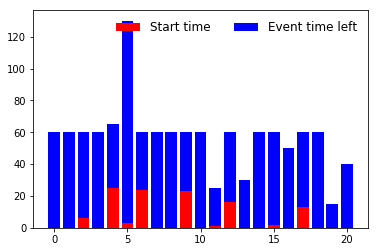

In [13]:
# Delay graph, red is how much the movement segmentation missed
values = [i['movementSegmentStartDelay'] for i in segments]
values2 =[i['duration'] - i['movementSegmentStartDelay'] for i in segments]
indices = np.arange(len(values))
p1 = plt.bar(indices, values, color='r')
p2 = plt.bar(indices, values2 , bottom=values, color='b')
plt.legend((p1[0], p2[0]), ("Start time", "Event time left"), fontsize=12, ncol=4, framealpha=0, fancybox=True)
plt.show()

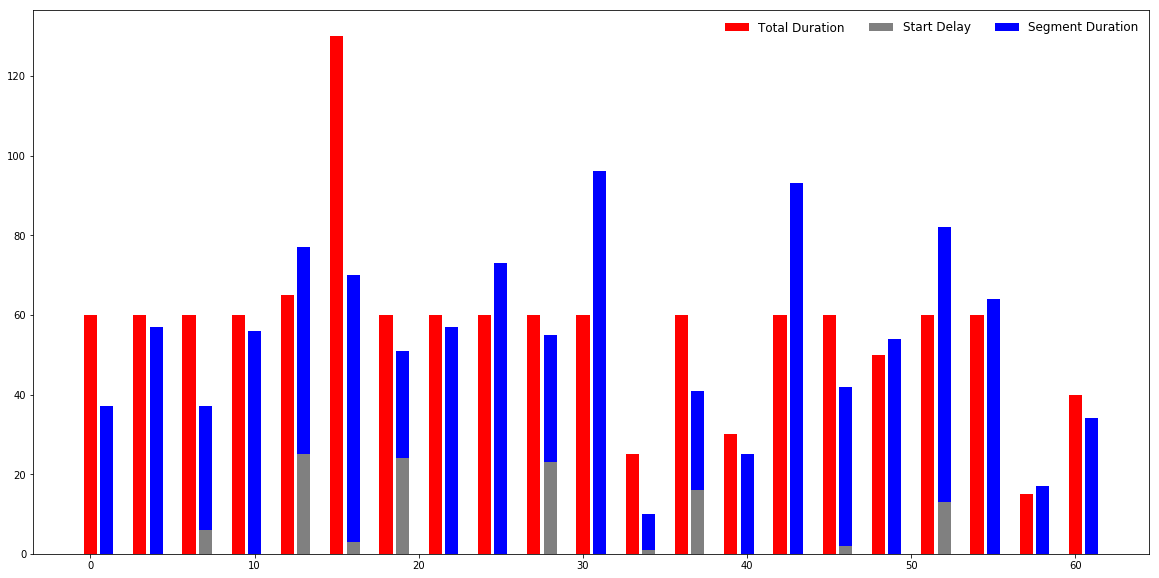

In [14]:
# Duration comparison, the more overlap between the blue and red the better
plt.figure(figsize=(20,10))
eventDuration = [i['duration'] for i in segments]
segStart = [i['movementSegmentStartDelay'] for i in segments]
segDuration = [i['movementSegmentLength'] for i in segments]

indices = np.arange(len(values)*3,step=3)
p1 = plt.bar(indices, eventDuration, color='r')
p2 = plt.bar(indices+1, segStart, color='grey')
p3 = plt.bar(indices+1, segDuration , bottom=segStart, color='b')

plt.legend((p1[0], p2[0],p3[0]), ("Total Duration", "Start Delay", "Segment Duration"), fontsize=12, ncol=4, framealpha=0, fancybox=True)
plt.show()